# Sample Calling


In [1]:
import pandas as pd
import numpy as np

Phenotype_df = pd.read_csv("/home/jupyter/workspaces/multiallelicgenesinvestigation/cardiovascular_phenotype_df_for_set1234.csv", header = 0, index_col = 0)
Allele_df = pd.read_csv("/home/jupyter/workspaces/multiallelicgenesinvestigation/allele_df_for_set1234.csv", header = 0, index_col = 0)

Phenotype_df = Phenotype_df.replace(np.nan,0)
Allele_df = Allele_df.replace(np.nan,0)

In [6]:
print(Allele_df.shape)
print(Phenotype_df.shape)

(2119, 66)
(2130, 1090)


In [2]:
## Unify Input - Output data
Phenotype_df=Phenotype_df[Phenotype_df.index.isin(list(Allele_df.index))]

print(Phenotype_df.shape)
print(Allele_df.shape)

(2119, 1090)
(2119, 66)


## Population Stratification

In [5]:
# from sklearn.model_selection import train_test_split
Phenotype_df['cluster'] = Phenotype_df['cluster'].replace('None Indicated-Black or African American','Male-Black or African American')

v_count = Phenotype_df['cluster'].value_counts()

# There is only one case of 'none-black'
exclude =[]
for key in v_count.index:
    if v_count[key] == 1:
        exclude += [key]
        
ex_idx = []        
for ex in exclude:        
    ex_idx+=Phenotype_df.index[Phenotype_df['cluster'] == ex].tolist()

out_df = Phenotype_df.drop(ex_idx,axis =0)

In [11]:
print(v_count)

Male-White-Not Hispanic or Latino                                  419
Female-White-Not Hispanic or Latino                                382
Female-Black or African American-Not Hispanic or Latino            336
Female-Asian-Not Hispanic or Latino                                269
Male-Asian-Not Hispanic or Latino                                  222
Male-Black or African American-Not Hispanic or Latino              191
Female-None Indicated-Hispanic or Latino                           114
Male-None Indicated-Hispanic or Latino                              68
Male-None Indicated-None Indicated                                  12
Female-None Indicated-None Indicated                                12
Female-Asian-Hispanic or Latino                                     11
Female-More than one population-Not Hispanic or Latino              10
Female-Black or African American-Hispanic or Latino                  9
None Indicated-None Indicated-None Indicated                         8
Male-M

In [12]:
# ## Manual Stratification

# X1 = out_df[out_df['cluster']=='Female-Black or African American-Not Hispanic or Latino'].iloc[:152,:]
# X2 = out_df[out_df['cluster']=='Male-White-Not Hispanic or Latino'].iloc[:152,:]
# X3 = out_df[out_df['cluster']=='Female-White-Not Hispanic or Latino'].iloc[:152,:]
# X4 = out_df[out_df['cluster']=='Male-Black or African American-Not Hispanic or Latino'].iloc[:152,:]

# X_stratified = pd.concat([X1,X2,X3,X4], axis =0)
# Y = Allele_df

In [15]:
# X_stratified = X_stratified[~X_stratified.index.duplicated(keep='first')]
# Y_stratified = Y[Y.index.isin(list(X_stratified.index))]
# Y_stratified = Y_stratified[~Y_stratified.index.duplicated(keep='first')]

# X_stratified = X_stratified.sort_index(axis=0)
# Y_stratified = Y_stratified.sort_index(axis=0)
# print(list(X_stratified.index) == list(Y_stratified.index))


# if (list(X_stratified.index) == list(Y_stratified.index)):
#     X_stratified = X_stratified.iloc[:,:1037]
    
    
# print(X_stratified.shape)
# print(Y_stratified.shape)


## Without Population Stratification for Generalized Model

In [3]:
global f
f = Phenotype_df.shape[1]-5

X = Phenotype_df.iloc[:,:f]
X_group = Phenotype_df.iloc[:,f:]
Y = Allele_df
X = X.sort_index(axis=0)
X_group = X_group.sort_index(axis=0)
Y = Y.sort_index(axis=0)
print(list(X.index) == list(Y.index))

True


In [4]:
import numpy as np

# categorical 
X_array = np.array(X)

# Encoding Y to continuous/binary/categorical
def continuous_ecd(Y):
    return np.array(Y)

def binary_ecd(Y):
    return np.where(Y > 0, 1, Y)

def categoric_ecd(Y, Y_binary):
    Y_category_dict = {}
    for i in range(len(Y_binary)):
        array = Y_binary[i]
        allele = Y.columns[np.where(Y_binary[i] == 1)[0].tolist()].tolist()
        value = "/".join(allele)
        key = Y.index[i]
        Y_category_dict[key] = value
    
    return Y_category_dict
    


# PheWAS study - Modeling

## GLMM (vector)
use binary data

In [282]:
#!pip3 install gpboost -U
import gpboost as gpb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 21.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [305]:
from sklearn.model_selection import train_test_split

i = 0
# Xg_train, Xg_test, Yg_train, Yg_test = train_test_split(X_array,Y_binary[:,i] ,
#                                    random_state=100, 
#                                    test_size=0.40, 
#                                    shuffle=True)

In [343]:
gp_model = gpb.GPModel(group_data=np.array(X_group), likelihood="binary")
gp_model.fit(X=X_array, y=Y_binary[:,0], params = {"std_dev":True})
gp_model.summary()


[GPBoost] [Warning] The covariate data contains no column of ones, i.e., no intercept is included.
[GPBoost] [Warning] The linear regression covariate data matrix (fixed effect) is rank deficient. This is not necessarily a problem when using gradient descent. If this is not desired, consider dropping some columns / covariates.
Model summary:
 Log-lik     AIC     BIC
 -349.02 2782.04 8251.72
Nb. observations: 1407
Nb. groups: 26 (Group_1), 4 (Group_2), 7 (Group_3), 4 (Group_4), 71 (Group_5)
-----------------------------------------------------
Covariance parameters (random effects):
         Param.
Group_1  0.0003
Group_2  0.0000
Group_3  0.0000
Group_4  0.0001
Group_5  0.0001
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                Param.     Std. dev.  z value  P(>|z|)
Covariate_1    -0.6560  1.851758e+06  -0.0000   1.0000
Covariate_2     0.0629           NaN      NaN      NaN
Covariate_3     0.7628           NaN      NaN   

In [42]:
# coefs = gp_model.get_coef()
# z_values = coefs[0] / coefs[1]
# p_values = 2 * stats.norm.cdf(-np.abs(z_values))
# print(p_values) # show p-values

## Binary Logistic Regression (matrix)

In [50]:
# X: (315, 941) m,n
# Y: (315, 44) m,c 
# w: (941, 44) n,c 
# b: vector of size 44

# z: (315, 44)

In [51]:
def softmax(z):  
    tmp = np.zeros((315, 44))
    for i in range(len(z)):    # Calculating softmax for all examples.
        exp = np.exp(z[i]-np.max(z[i]))
        tmp[i] = exp/np.sum(exp)
        
    return tmp

# w = np.random.random((941, 44))
# b = np.random.random(44)
# z = X1_array@w + b

# s = softmax(z)
# for i in range(len(s)):
#     print(sum(s[i]))

In [52]:
def sigmoid(z):  
    return 1/(1+np.exp(-z))

In [53]:
# def crossEntropyError(y, y_hat):
#     delta = 1e-7 #not allowing -inf 
#     return -np.sum(y*np.log(y_hat+delta)) 

def cost(y, y_hat):
    delta = 1e-7 
    return -(np.multiply(y,np.log(y_hat+delta)) + np.multiply((1 - y),np.log(1 - y_hat+delta))).mean()

In [54]:
import numpy as np
def fit (X, y, lr, c, epochs):
    m,n = X.shape # m= num of sample, n = num of features
    
    #initialize w, b
    w = np.random.random((n,c))
    b = np.random.random(c)
    
    #empty list to store losses
    losses = []
    
    #training
    for epochs in range(epochs):
        
        z = X@w + b
        y_hat = sigmoid(z)
        
        w_grad = (1/m)*np.dot(X.T, (y_hat - y)) # cost 함수 편미분 (proved)
        b_grad = (1/m)*np.sum(y_hat - y)
        
        w = w -lr*w_grad
        b = b -lr*b_grad

        loss = cost(y, y_hat)
        losses.append(loss)
        
        if epochs % 100 == 0:
            print('Epoch {epoch} ==> Loss = {loss}'.format(epoch = epochs, loss = loss))
    return w,b,losses

In [55]:
# def predict(X, w, b):
#     # Predicting
#     z = X@w + b
#     y_hat = sigmoid(z)
    
#     return np.argmax(y_hat, axis=1) #(the class with highest probability.)

In [56]:
def predict_prob(X, w, b):
    # Predicting
    z = X@w + b
    y_hat = sigmoid(z)
    
    return y_hat #(the class with highest probability.)



In [129]:
def accuracy(y, y_hat, colname): # colname == allele name
    acc_of_column_list = []
    for i in range(y.shape[1]):
        acc_of_column = np.sum(y[:,i]==y_hat[:,i])/(y.shape[0])
        acc_of_column_list += [round(acc_of_column*100,2)]
        print("Accuracy of "+str(colname[i])+"*: "+str(acc_of_column))
        
        acc_toal = (np.sum(y==y_hat)/(y.shape[0]*y.shape[1]))*100
        
    return acc_toal, acc_of_column_list

In [81]:
Y_binary = binary_ecd(Y)
X_array = np.array(X)

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_array,Y_binary,
                                                   random_state=104, 
                                                   test_size=0.25, 
                                                   shuffle=True)

In [86]:
## Model Training
w,b,losses = fit(X_train, Y_train, lr = 0.05, c = Y_train.shape[1], epochs = 5000)

Epoch 0 ==> Loss = 14.458728589644807


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Epoch 100 ==> Loss = 0.5890675417561954
Epoch 200 ==> Loss = 0.47270342612254546
Epoch 300 ==> Loss = 0.43838103342375334
Epoch 400 ==> Loss = 0.4269054462873178
Epoch 500 ==> Loss = 0.38926189179365217
Epoch 600 ==> Loss = 0.3941651809601145
Epoch 700 ==> Loss = 0.3488995671389994
Epoch 800 ==> Loss = 0.33929735846573034
Epoch 900 ==> Loss = 0.3727781332361394
Epoch 1000 ==> Loss = 0.34376797836420087
Epoch 1100 ==> Loss = 0.3405233189445114
Epoch 1200 ==> Loss = 0.2955044969083998
Epoch 1300 ==> Loss = 0.29320084504273664
Epoch 1400 ==> Loss = 0.33062899455696537
Epoch 1500 ==> Loss = 0.325056697207918
Epoch 1600 ==> Loss = 0.25950304349948894
Epoch 1700 ==> Loss = 0.2982073217944081
Epoch 1800 ==> Loss = 0.3525503164501646
Epoch 1900 ==> Loss = 0.286269933573383
Epoch 2000 ==> Loss = 0.2997330668340526
Epoch 2100 ==> Loss = 0.2987966125817266
Epoch 2200 ==> Loss = 0.28974664358820634
Epoch 2300 ==> Loss = 0.26211250281530624
Epoch 2400 ==> Loss = 0.27324188964749213
Epoch 2500 ==> L

In [130]:
## Model Testing
predict = predict_prob(X_test, w, b).round() # decision boundary = 0.5
predict_mtx = predict.astype(int)

total_acc, acc_list = accuracy(Y_test, predict_mtx, list(Y.columns))

Accuracy of 1*: 0.41761363636363635
Accuracy of 2*: 0.44886363636363635
Accuracy of 3*: 0.8948863636363636
Accuracy of 4*: 0.6448863636363636
Accuracy of 6*: 0.9289772727272727
Accuracy of 7*: 0.9517045454545454
Accuracy of 8*: 0.9715909090909091
Accuracy of 9*: 0.8494318181818182
Accuracy of 10*: 0.8551136363636364
Accuracy of 12*: 0.9460227272727273
Accuracy of 17*: 0.8551136363636364
Accuracy of 22*: 0.9573863636363636
Accuracy of 27*: 0.9602272727272727
Accuracy of 28*: 0.9261363636363636
Accuracy of 29*: 0.8920454545454546
Accuracy of 31*: 0.9545454545454546
Accuracy of 32*: 0.9289772727272727
Accuracy of 33*: 0.9119318181818182
Accuracy of 34*: 0.9545454545454546
Accuracy of 35*: 0.8039772727272727
Accuracy of 36*: 0.9090909090909091
Accuracy of 39*: 0.9204545454545454
Accuracy of 40*: 0.9715909090909091
Accuracy of 41*: 0.8210227272727273
Accuracy of 43*: 0.9090909090909091
Accuracy of 45*: 0.8607954545454546
Accuracy of 46*: 0.9232954545454546
Accuracy of 53*: 0.960227272727272

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [140]:
print(total_acc)

90.809132996633


## binary logistic regression result visualization

In [134]:
sorted_allele, sorted_accuracy = zip(*sorted(zip(acc_list, list(Y.columns))))

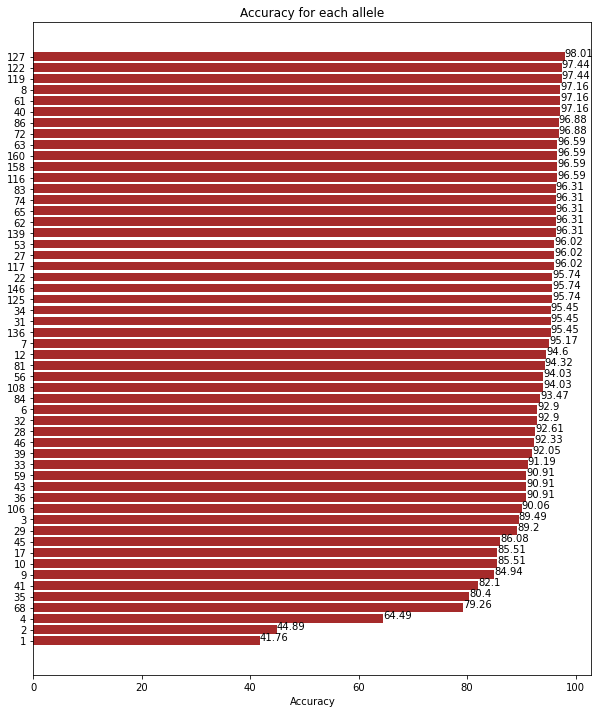

In [139]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,12))
plt.barh(sorted_accuracy, sorted_allele, color = 'brown')

for index, value in enumerate(sorted_allele):
    plt.text(value, index,
             str(value))
    
plt.title("Accuracy for each allele")
plt.xlabel("Accuracy")
plt.show()



In [292]:
coeff_mtx

,1,2,3,4,6,7,8,9,10,12,...,117,119,122,125,127,136,139,146,158,160
4116486,1.044925,0.586508,0.641071,0.876775,0.562913,0.703707,0.648600,0.366539,0.070439,0.015568,...,0.432590,0.034834,0.431414,0.591402,0.372334,0.876836,0.638313,0.199392,0.049692,0.970950
4153352,-0.748539,-0.611099,0.082313,0.354497,0.414778,0.134322,0.476683,0.435893,0.305170,0.178068,...,0.776895,0.617366,0.932234,0.938519,0.804053,0.133765,-0.063158,0.053100,0.236925,0.339608
4124683,0.391374,0.472562,0.492304,0.940219,0.100817,0.773768,0.902161,0.829649,0.269938,0.661274,...,0.380331,0.294180,0.425433,0.845179,0.256281,0.318984,0.864110,0.558474,0.570505,0.575376
44783628,0.718509,0.240391,0.056357,0.292580,0.482816,0.353265,0.909611,0.363707,0.628545,0.262639,...,0.330535,0.572027,0.302770,-0.000545,0.107171,0.789522,0.801483,0.277570,0.266967,0.056119
4268046,0.596702,0.259220,0.443880,0.352198,0.520497,0.207604,0.333103,0.621601,0.058408,0.044223,...,0.922406,0.771695,0.541303,0.620927,0.474144,0.179360,0.144562,0.120771,0.034656,0.627496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147187,0.016734,0.105106,0.456592,0.215920,0.370139,0.183687,0.492473,0.011306,0.940616,0.405392,...,0.464117,0.997500,0.641313,0.387808,0.485886,0.003406,0.017399,0.669989,0.428925,0.409828
135157,0.696162,0.451179,0.801061,0.806865,0.315280,0.832641,0.049994,0.551622,0.783418,0.851718,...,0.443323,0.047138,0.898322,0.244862,0.069775,0.472931,0.101904,0.305854,0.432015,0.055355
444406,-1.412594,-0.185565,-0.074109,-1.217950,-0.557619,0.228116,0.753139,-0.256099,0.464254,-0.105735,...,0.089490,0.689431,0.527468,0.042875,0.242740,0.126962,0.646007,0.558277,0.249559,0.709653
4173819,0.951924,0.711996,0.061403,0.438887,0.921398,0.677006,0.194869,0.451222,0.265543,0.373644,...,0.309971,0.350185,0.238718,0.071023,0.376372,0.819521,0.873632,0.447131,0.775830,0.243334


Text(0.5, 0.98, 'Coefficient Values')

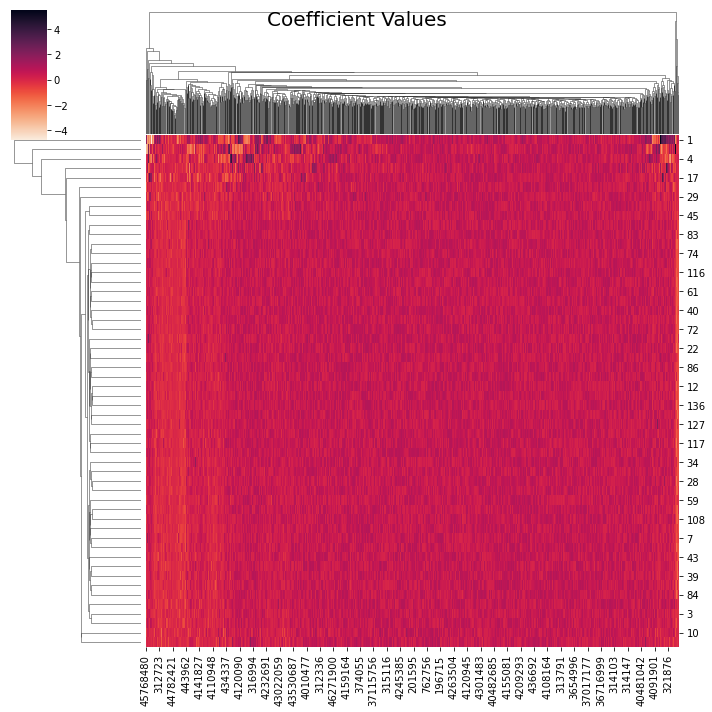

In [300]:
coeff_mtx = pd.DataFrame(w.T, index = allele_name, columns = pht_name)
p = sns.clustermap(coeff_mtx, cmap="rocket_r")
p.fig.suptitle("Coefficient Values", fontsize=20)

Text(0.5, 0.98, 'Coefficient Values')

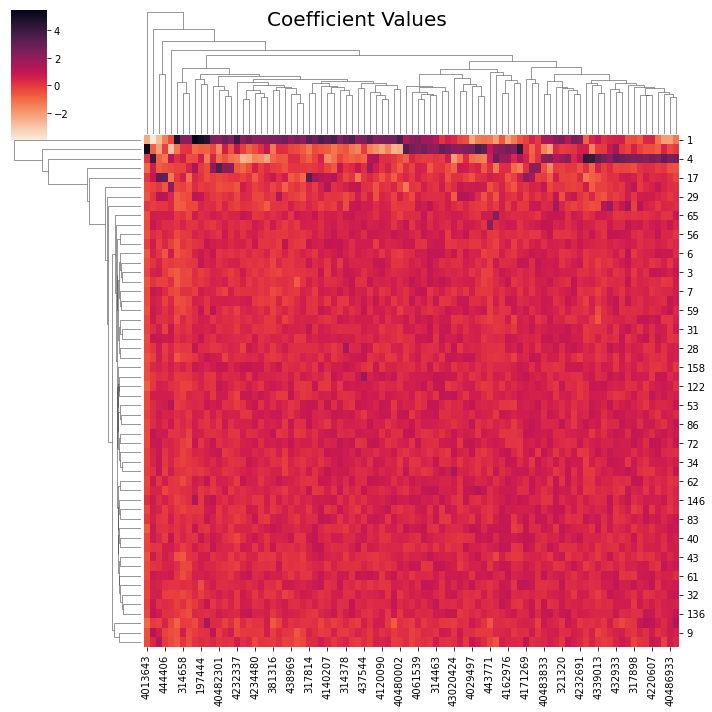

In [324]:
col = coeff_mtx.columns[coeff_mtx.max()>2]
high_coeff_mtx = coeff_mtx.loc[:,col]
p = sns.clustermap(high_coeff_mtx, cmap="rocket_r")
p.fig.suptitle("Coefficient Values", fontsize=20)

Text(0.5, 0.98, 'Coefficient Values')

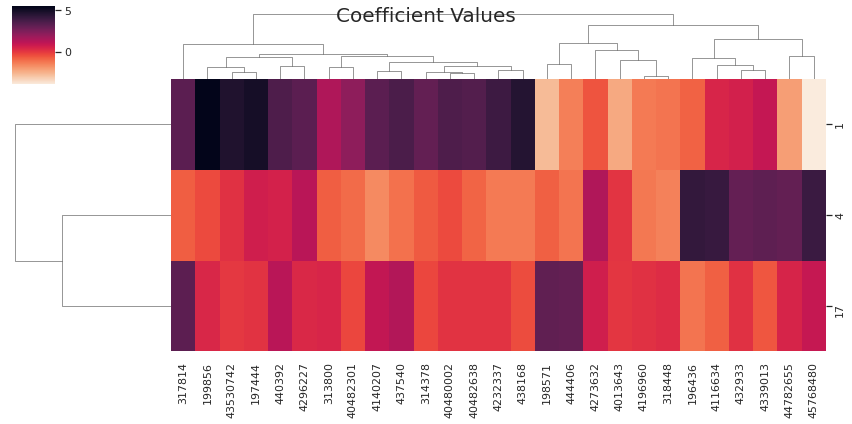

In [347]:
#sns.set(rc={"figure.figsize":(12, 4)})
col = coeff_mtx.columns[coeff_mtx.max()>3]
high_coeff_mtx = coeff_mtx.loc[['1','4','17'],col]


p = sns.clustermap(high_coeff_mtx, cmap="rocket_r", figsize=(12,6))
p.fig.suptitle("Coefficient Values", fontsize=20)

In [345]:
high_coeff_mtx

,440392,4116634,317814,313800,43530742,4196960,432933,197444,318448,314378,...,4273632,40482301,4296227,4013643,45768480,40482638,196436,438168,198571,444406
1,3.548740,0.403764,3.244404,1.399817,4.710081,-1.319361,0.559808,4.934845,-1.195345,3.079083,...,-0.586320,2.127695,3.262032,-2.332200,-3.947053,3.447327,-0.820109,4.574027,-2.748699,-1.412594
4,0.514325,4.110413,-0.754995,-0.778192,0.105930,-1.278165,3.048589,0.651063,-1.457271,-0.670495,...,1.388012,-1.025136,1.196474,0.033790,4.043458,-0.870076,4.229098,-1.298139,-0.812837,-1.217950
17,1.202563,-0.795990,3.236520,0.419024,-0.029268,0.140140,0.112597,0.076272,0.240598,-0.335241,...,0.644377,-0.314825,0.326979,0.021874,0.895344,0.085458,-1.186876,-0.430872,3.134512,3.085027


In [470]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc

# # Compute fpr, tpr, thresholds and roc auc
# fpr, tpr, thresholds = roc_curve(Y2_binary, predict)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
# plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate or (1 - Specifity)')
# plt.ylabel('True Positive Rate or (Sensitivity)')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")

## Nominal Logistic Regression
softmax

In [358]:
## remove allele combination < 2
#Y_category = categoric_ecd(Y_stratified, Y_binary)

from collections import Counter
Y_count = Counter(Y_category.values())
case = []
for i in Y_count:
    if Y_count[i] >1:
        case+= [i]

id_ = []
for person_id, allele in Y_category.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
    if allele in case :
        id_ += [person_id]
        
Y_cate = pd.DataFrame.from_dict(Y_category, orient='index', columns=['combination'])
Y_cate = Y_cate[Y_cate.index.isin(id_)].sort_index(axis=0)
X_cate = X_stratified[X_stratified.index.isin(id_)]

In [361]:
Y_category

{1000033: '4',
 1000570: '2/119',
 1002360: '1/8',
 1002546: '1/9',
 1002916: '4',
 1008186: '1',
 1009149: '2/4/68',
 1009211: '2/4',
 1009428: '1/4/68',
 1010670: '2/127',
 1014937: '1/2',
 1017022: '1/35',
 1032415: '1/2',
 1033138: '3/4',
 1040476: '1',
 1049411: '1/34',
 1057501: '1/10',
 1059806: '4',
 1063148: '17/84',
 1064996: '1/2',
 1065673: '2/41',
 1065912: '1/41',
 1066606: '1/41',
 1067056: '4/17',
 1067574: '1',
 1073911: '17/35',
 1075484: '4/17',
 1075691: '1/29',
 1076125: '1/10',
 1080512: '4/17',
 1082696: '2/29',
 1083172: '2/10/36',
 1083299: '1',
 1090093: '29/45',
 1097877: '1/22',
 1098278: '4/29',
 1099504: '1/4/68',
 1100351: '4/35',
 1106787: '1/4/68',
 1114604: '2/29',
 1115210: '1/2',
 1116300: '4/29',
 1116830: '1/2',
 1117314: '1',
 1124527: '1',
 1125322: '4/17',
 1130878: '2/4',
 1132189: '4/32',
 1132356: '1/4/68',
 1132586: '41',
 1133435: '17/29',
 1134802: '2/17',
 1139936: '1/33',
 1139940: '1/17',
 1140733: '1/2',
 1141902: '1/4/68',
 1143024: '

In [360]:
len(Y_category.values())

608

In [235]:
from sklearn.model_selection import train_test_split
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(np.array(X_cate),np.array(Y_cate['combination']) ,
                                   random_state=100, 
                                   test_size=0.40, 
                                   shuffle=True)

In [236]:
from sklearn.linear_model import LogisticRegression
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", random_state=42, max_iter = 700)
softmax_reg.fit(Xc_train, Yc_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(max_iter=700, multi_class='multinomial', random_state=42)

In [237]:
c_test_pred = softmax_reg.predict(Xc_test)

In [238]:
def nominal_accuracy(y,y_hat):
    return np.sum(y==y_hat)/len(y_hat)

In [239]:
print("Accuracy : ")
print(nominal_accuracy(Yc_test, c_test_pred))

Accuracy : 
0.06696428571428571


In [240]:
np.array(c_test_pred)

array(['17/29', '1/2', '17/29', '10/29', '17', '2', '1/2', '1/2', '1/10',
       '2/17', '1', '2', '1/41', '1', '1', '1', '1/2', '2/9', '10/29',
       '1/4', '2/29', '4/41', '1/17', '1/2', '2', '2/9', '4/9', '1/2',
       '1/2', '1/41', '1/4', '1/4', '1/2', '2/9', '1/29', '2/17', '4/41',
       '1/35', '4/17/68', '2/39', '2/10', '1/17', '1/2', '2', '1', '1',
       '1/17', '1/2', '1', '4', '1', '1/4', '10/29', '1/35', '1/17',
       '1/4', '17/29', '1/10', '1/41', '1/35', '2/9', '17/41', '1', '29',
       '1/35', '1/4', '4', '1', '1/4', '43', '2', '29', '4/41/68',
       '1/106', '4/68', '1', '1', '1', '1', '2/29', '1', '1/10', '10/17',
       '1', '1/106', '2', '4', '1', '1/2', '2', '1/17', '1/35', '4',
       '4/41', '1/35', '2/10', '1/41', '1/41', '2/29', '1/2', '2', '4/9',
       '1', '1', '1', '1', '2', '1', '2', '2/29', '4/17/68', '1/2',
       '1/35', '1', '1/4', '1/17', '17/41', '1/2', '2/29', '1/41', '1/2',
       '1/4', '1/17', '1/4', '1/17', '4/17', '2/35', '2/17', '4/17/68

In [241]:
np.array(Yc_test)

array(['1/17', '1/4/68', '1/41', '2/41', '1', '1/2', '4/9', '2', '1/45',
       '2/4', '1', '1/2', '2/4', '1/4/68', '1/35', '1/35', '1/2', '2/4',
       '4/41/68', '1/2', '1', '6/35', '1/41', '4/10', '2', '1/29', '4/29',
       '1/4', '2/29', '1', '2', '1', '1/4/68', '1/2', '17/29', '4/41',
       '1', '1/4', '1/35', '1', '1/4', '1/29', '1/17', '2', '2/41', '4',
       '1/116', '1/41', '1/9', '2/35', '4/35', '1/17', '1/106', '1/28',
       '1/2', '6/35', '4', '1', '1/17', '4', '1/10', '1/17', '1/4', '1/4',
       '2', '1/4/68', '1/4', '4/68', '2/29', '1', '1/35', '1/10', '1/2',
       '1/22', '1/2', '2/3', '1/35', '1/41', '35/41', '1/2', '1/10',
       '17/29', '1', '1', '4/9', '4', '1/4', '1', '1', '2/4', '2/29', '1',
       '1/4/68', '1/2', '1', '1/41', '2/4/68', '17', '1', '17', '1/4',
       '17', '2/17', '2/41', '41', '1', '41', '1/17', '1', '2/17', '4/17',
       '1/2', '1/10', '2/4', '10/17', '2/29', '1/2', '17', '1/41', '1/4',
       '10/29', '4/41', '1/45', '2', '1/2', '1/17',

# Regression Result Visualization

In [242]:
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.feature_selection import chi2

In [243]:
X, y = Xc_test, Yc_test
scores, pvalues = chi2(Xc_test, Yc_test)

In [257]:
pvalues[~np.isnan(pvalues)]

array([1.22581769e-026, 7.30580146e-004, 1.00000000e+000, 9.85193178e-001,
       1.17290221e-143, 8.34036316e-014, 7.24577666e-024, 6.01664683e-003,
       1.04082507e-006, 0.00000000e+000, 7.21859031e-044, 3.50128084e-230,
       9.37979678e-208, 8.92352815e-012, 1.13202710e-004, 8.92352815e-012,
       8.68354641e-181, 9.99162694e-001, 9.99999307e-001, 6.35980314e-001,
       1.00000000e+000, 1.56777869e-002, 2.71139828e-017, 5.08904288e-217,
       0.00000000e+000, 4.66307034e-109, 1.04082507e-006, 6.83348002e-001,
       2.95652164e-002, 1.85850663e-015, 9.85193178e-001, 9.97793253e-001,
       2.33860189e-007, 2.40687051e-005, 9.86199928e-001, 2.00682698e-044,
       1.06792478e-051, 9.99999307e-001, 5.50197604e-003, 9.99999508e-001,
       9.99999307e-001, 1.00000000e+000, 1.76872273e-002, 1.00000000e+000,
       7.67742125e-006, 0.00000000e+000, 0.00000000e+000, 9.89769347e-001,
       6.67497867e-011, 1.04082507e-006, 1.05848976e-007, 1.65731428e-002,
       1.07564550e-023, 2

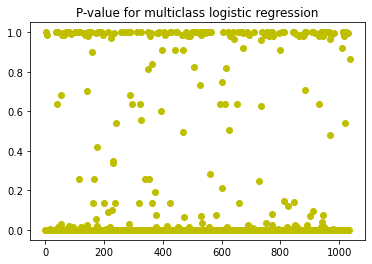

In [262]:
import matplotlib.pyplot as plt

plt.title('P-value for multiclass logistic regression')
plt.plot(pvalues, 'yo')

# PheWAS study

## Phenotype Referece data calling for mapping

In [5]:
import pandas
import os

# This query represents dataset "All_WGS" for domain "condition" and was generated for All of Us Controlled Tier Dataset v6
dataset_02785573_condition_sql = """
    SELECT
        c_occurrence.person_id,
        c_occurrence.condition_concept_id,
        c_standard_concept.concept_name as standard_concept_name 
    FROM
        ( SELECT
            * 
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.condition_occurrence` c_occurrence 
        WHERE
            (
                condition_concept_id IN  (
                    SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (
                            select
                                cast(cr.id as string) as id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                            WHERE
                                concept_id IN (
                                    4101343, 4086181, 4000610, 4022923, 4091532, 4024013, 4006969, 201891, 4028076, 376106, 4090426, 4134294, 4297887, 4021667, 4199402, 444089, 4101212, 4022922, 4175154, 4179167, 437515, 4000609, 40480457, 376337, 4269314, 4083787, 138239, 4002905, 4054501, 4047779, 134057, 4020346, 4021915, 200174, 37018424, 4041436, 321588, 373499, 4009890, 4117779, 4170962, 4038678, 200452, 4168335, 31610, 441542, 4023995, 436670, 4201745, 43530815, 4100932, 37206233, 4094294, 440371, 4038677, 443343, 4198525, 443723, 4190185, 4028387, 4317258, 134736, 4091363, 320128, 4132555, 4212577, 40484102, 75909, 133468, 4011630, 4181063, 4150129, 135930, 4022201, 4038502, 444100, 4301699, 4043671, 4096864, 4180154, 40481841, 40484533, 4179873, 255919, 4080992, 4024000, 4180170, 4318379, 432867, 4267789, 4316083, 4260918, 432586, 4134440, 4113563, 4277352, 4024561, 4185640, 443883, 4293175, 443784, 4093991, 440383, 254068, 4266186, 4027384, 4022924, 4095793, 4184252, 140190, 4081176, 4178818, 444363, 4043371, 4182633, 254761, 4339468, 435524, 4102111, 4043346, 193460, 4115390, 4304916, 4213101, 4042140, 43531056, 43531057, 4042503, 444112, 4302537, 4024567, 4002898, 4178680, 4071689, 4182165, 37203927, 77960, 4115259, 4042056, 37018713, 4024566, 443783, 4116811, 141960, 44782620, 4103352, 4244662, 43531054, 435506, 138525, 4276572, 4308811, 4093227, 4162282, 43021226, 4180169, 201618, 37311678, 433128, 4170143, 4051221, 4179871, 4170226, 4185503, 4091213, 4103320, 43531053, 75865, 4093228, 4031814, 4247371, 73553, 4027553, 4200532, 4025215, 442077, 37311677, 440029, 433736, 440921, 4178545, 200219, 4115386, 375252, 40481517, 4221108, 4021780, 4181187, 444108, 432795, 4305027, 77074, 432250, 316866, 42538830, 4041285, 320136, 4329041, 4274025, 4042837, 4182161, 4197094, 376208, 4132926, 4276569, 44783587, 43531060, 253549, 4206591, 4227253, 4028071, 4309188, 4041284, 4113999, 4117930, 4160062, 192438, 4042836, 4180628, 4104157, 4171379, 4042142, 4338120, 77670, 440142, 43531059, 4179141, 4090614, 44784102, 318800, 4041283, 43530877, 436096, 4042505, 4042835, 40484935, 4013518, 4272867, 79106, 4042141, 31821, 43531058, 4103183, 4090615, 4101796, 4208786, 4344497, 80180, 4339410, 438112
                                ) 
                                AND full_text LIKE '%_rank1]%'
                        ) a 
                            ON (
                                c.path LIKE CONCAT('%.',
                            a.id,
                            '.%') 
                            OR c.path LIKE CONCAT('%.',
                            a.id) 
                            OR c.path LIKE CONCAT(a.id,
                            '.%') 
                            OR c.path = a.id) 
                        WHERE
                            is_standard = 1 
                            AND is_selectable = 1
                        )
                )  
                AND (
                    c_occurrence.PERSON_ID IN (
                        SELECT
                            distinct person_id  
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                        WHERE
                            cb_search_person.person_id IN (
                                SELECT
                                    person_id 
                                FROM
                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                                WHERE
                                    has_whole_genome_variant = 1 
                            ) 
                        )
                )
            ) c_occurrence 
        LEFT JOIN
            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_standard_concept 
                ON c_occurrence.condition_concept_id = c_standard_concept.concept_id"""

dataset_02785573_condition_df = pandas.read_gbq(
    dataset_02785573_condition_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_02785573_condition_df.head(5)

Downloading:   0%|          | 0/21251938 [00:00<?, ?rows/s]

,person_id,condition_concept_id,standard_concept_name
0,1330258,136497,Scar conditions and fibrosis of skin
1,1829281,260123,Acute sinusitis
2,3517751,40483262,Arthritis of shoulder region joint
3,1345369,435569,Disorder of jaw
4,1196380,140352,"Acute myeloid leukemia, disease"


In [6]:
concept_ancestor_sql = """
    SELECT DISTINCT ancestor_concept_id, descendant_concept_id, min_levels_of_separation, max_levels_of_separation
    FROM `fc-aou-cdr-prod-ct.C2022Q2R6.concept_ancestor`
    """

concept_ancestor = pandas.read_gbq(
    concept_ancestor_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

concept_ancestor.head(5)


Downloading:   0%|          | 0/78065523 [00:00<?, ?rows/s]

,ancestor_concept_id,descendant_concept_id,min_levels_of_separation,max_levels_of_separation
0,441840,3656953,7,12
1,4219713,42539392,4,11
2,441840,36548123,5,16
3,4240671,4177484,5,17
4,4047779,36562813,7,14


In [7]:
global ref_condition 
ref_condition = dataset_02785573_condition_df
global concept_ancestor_mapped 
concept_ancestor_mapped = concept_ancestor.copy()

## Workflow
1. Chi-Square Test

2. ID-Name Mapping

3. Manhattan Plot

In [26]:
p_df = P
a_df = A


a_mtx = binary_ecd(a_df)
p_mtx = binary_ecd(p_df.iloc[:,:f])

#patient_list = list(Phenotype_df.iloc[:,:f].index)
allele_list = list(a_df.columns)
condition_list= list(p_df.iloc[:,:f].columns) 

x = [] # condition
y = [] # allele
z = [] # log p-value


In [33]:
for i in range(p_mtx.shape[1]):
    for j in range(a_mtx.shape[1]):
        c_col = list(p_mtx[:,i])
        a_col = list(a_mtx[:,j])

        a = len([p for p, q in zip(c_col, a_col) if (p==1 and q==1)])
        b = len([p for p, q in zip(c_col, a_col) if (p==1 and q==0)])
        c = len([p for p, q in zip(c_col, a_col) if (p==0 and q==1)])
        d = len([p for p, q in zip(c_col, a_col) if (p==0 and q==0)])

        if a == 0 : a +=  1e-14 
        if b == 0 : b +=  1e-14 
        if c == 0 : c +=  1e-14 
        if d == 0 : d +=  1e-14 
        

        table = [[a,b],[c,d]]
        stat, p, dof, expected = chi2_contingency(table)

        x+= [condition_list[i]]
        y+= [allele_list[j]]
        z+= [-math.log10(p)]

In [34]:
from scipy.stats import chi2_contingency
import math

##########################
# <Input>
# Allele dataframe
# Phenotype dataframe
#
# <shape of "table">
# allele |   O  |   X
#-------------------------
# cond O |   a      b
#      X |   c      d
#-------------------------

def chi_square (p_df, a_df):
        
    # p_mtx : binary-encoded matrix (sample * concept_id)
    # a_mtx : binary-encoded matrix (sample * star allele)
    
    
    if list(p_df.index) == list(a_df.index) :
        a_mtx = binary_ecd(a_df)
        p_mtx = binary_ecd(p_df.iloc[:,:f])

        #patient_list = list(Phenotype_df.iloc[:,:f].index)
        allele_list = list(a_df.columns)
        condition_list= list(p_df.iloc[:,:f].columns) 

        x = [] # condition
        y = [] # allele
        z = [] # log p-value

        for i in range(p_mtx.shape[1]):
            for j in range(a_mtx.shape[1]):
                c_col = list(p_mtx[:,i])
                a_col = list(a_mtx[:,j])

                a = len([p for p, q in zip(c_col, a_col) if (p==1 and q==1)])
                b = len([p for p, q in zip(c_col, a_col) if (p==1 and q==0)])
                c = len([p for p, q in zip(c_col, a_col) if (p==0 and q==1)])
                d = len([p for p, q in zip(c_col, a_col) if (p==0 and q==0)])

                if a == 0 : a +=  1e-14 
                if b == 0 : b +=  1e-14 
                if c == 0 : c +=  1e-14 
                if d == 0 : d +=  1e-14 

                table = [[a,b],[c,d]]
                stat, p, dof, expected = chi2_contingency(table)

                x+= [condition_list[i]]
                y+= [allele_list[j]]
                z+= [-math.log10(p)]


        x = np.array(x).astype(int)
        y = np.array(y).astype(int)
        z = np.array(z)

        chi_output = pd.DataFrame({'condition_concept_id': x,'allele': y,'log_p-value': z})

        return chi_output
    
    else:
        print("ERROR : index does not match : p_df, a_df")

In [13]:
## run the code for bringing "ref_condition" first
## mapping concept id - concept name

def mtx_mapping(mtx1, mtx2, col1, col2, new_column):
    
    #-----------------------------------------------------------------------------
    ## bring new column corresponding to standard column from mtx1 to mtx2 
    ## mtx1 : reference matrix for mapping
    ## mtx2 : target matrix
    ## col1 : standard column of mtx1 
    ## col2 : standard column of mtx2 
    ## new_column : the column of mtx1 which will be added to mtx2, corresponding to col2.
    #-----------------------------------------------------------------------------
    
    tmp_df = mtx2
    
    tmp = mtx1[mtx1[col1].isin(mtx2[col2].astype(int))]
    tmp = tmp.drop_duplicates()
    
    tmp_dict = pd.Series(tmp[new_column].values, tmp[col1].values).to_dict()
    
    tmp_df[new_column] = mtx2[col2].map(tmp_dict)
    
    return tmp_df
    

In [14]:
from pandas import DataFrame
from scipy.stats import uniform
from scipy.stats import randint
import numpy as np
import matplotlib.pyplot as plt

In [36]:
def manhattan_plot(df, a, rs = None): ## df = sorted_chi_output_mapped, a = allele, rs = rs position
    
    # ============================================
    # *** Modify x-label, title, and file name ***
    # ============================================

    df_1 = df[df['allele']==a]
    M_df_1 = df_1.loc[:,['condition_concept_id', 'log_p-value', 'ancestor_concept_id']] # data point, p-value, group
    M_df_1 = M_df_1.groupby('ancestor_concept_id').filter(lambda x : len(x)>1)

    M_df_1.ancestor_concept_id = M_df_1.ancestor_concept_id.astype('category')
    M_df_1 = M_df_1.sort_values('ancestor_concept_id')
    M_df_1['ind'] = range(len(M_df_1))
    M_df_1_grouped = M_df_1.groupby('ancestor_concept_id')


    # manhattan plot
    fig = plt.figure(figsize=(40, 8)) # Set the figure size
    ax = fig.add_subplot(111)
    colors = ['darkred','darkgreen','darkblue', 'gold']

    x_labels = []
    x_labels_pos = []

    for num, (name, group) in enumerate(M_df_1_grouped):
        group.plot(kind='scatter', x='ind', y='log_p-value',color=colors[num % len(colors)], ax=ax)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))

    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels, rotation =90)

    # set axis limits
    ax.set_xlim([0, len(M_df_1)])
    ax.set_ylim([0, 3.5])

    # x axis label
    ax.set_xlabel('Ancestor Concept ID')

    # show the graph
   
    if rs != None:
        plt.title(rs + "+ *"+str(a))
        plt.show()
        plt.savefig('/home/jupyter/workspaces/multiallelicgenesinvestigation/plot/manhattan_plot_'+rs+"_"+str(a)+'.png')
        
    else:
        plt.title("Star Allele *"+str(a))
        #plt.savefig('/home/jupyter/workspaces/multiallelicgenesinvestigation/plot/manhattan_plot_*'+str(a)+'.png')
        
        

In [16]:
def PheWAS(p_df, a_df):
    
    #======== 1. Chi-Square Test ===============

    chi_output = chi_square(p_df, a_df)
    sorted_chi_output = chi_output.sort_values('log_p-value', ascending=False)
    
    #======== 2. Data Column Mapping ===========

    ## chi-square table + ancestor_id
    sorted_chi_output_mapped = mtx_mapping(concept_ancestor_mapped, sorted_chi_output, 'descendant_concept_id','condition_concept_id','ancestor_concept_id')
    ## chi-square table + ancestor_id + ancestor_name
    sorted_chi_output_mapped = mtx_mapping(ref_condition, sorted_chi_output_mapped, 'condition_concept_id','ancestor_concept_id','standard_concept_name')

    
    #======== 3. Create label table (concept ID - concept NAME) =========
    s_ = sorted_chi_output_mapped.copy()
    s_ = s_[['ancestor_concept_id','standard_concept_name']]
    s_ = s_.groupby('ancestor_concept_id').filter(lambda x : len(x)>1)
    s_unique = s_.drop_duplicates().sort_values('ancestor_concept_id')
    
    
    return  sorted_chi_output_mapped, s_unique
    

## Manhattan Plotting

In [88]:
sorted_chi_output_mapped, sorted_table = PheWAS(Phenotype_df,Allele_df) ## the sorted_chi_output_mapped should be same as the one written already.
allele = list(set(sorted_chi_output_mapped['allele']))
for a in allele:
    manhattan_plot(sorted_chi_output_mapped, a)

## 3D Plotting

In [104]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


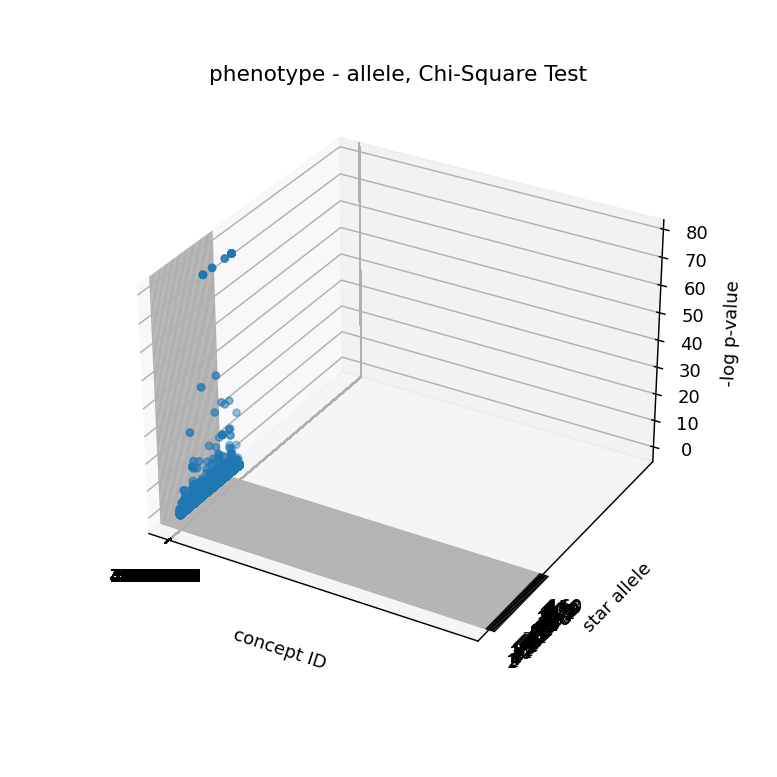

In [106]:
%matplotlib notebook
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, marker='o', s=15, cmap='Greens')

ax.set_title("phenotype - allele, Chi-Square Test")
ax.set_xlabel("concept ID")
ax.set_ylabel("star allele")
ax.set_zlabel("-log p-value")

plt.show()

# Correlation

In [11]:
# N = Phenotype_df.shape[0]

# allele_mtx = binary_ecd(Allele_df)
# pht_mtx = binary_ecd(Phenotype_df.iloc[:,:1037])

# sample_name = list(Phenotype_df.iloc[:,:1037].index)
# allele_name = list(Allele_df.columns)
# pht_name = list(Phenotype_df.iloc[:,:1037].columns)

# pair_list = [] # sample, allele, phenotype
# for i in range(N):
#     sample = sample_name[i]
#     allele_row = list(allele_mtx[i,:])
#     pth_row = list(pht_mtx[i,:])
    
#     if (1 in allele_row) and (1 in pth_row):
    
#         allele_idx = [allele_row.index(1)] # i번째 sample의 allele
#         pht_idx = [pth_row.index(1)] #i번째 sample의 pht

#         for x in allele_idx:
#             for y in pht_idx:
#                 tmp = [sample, allele_name[x], pht_name[y]]
#                 pair_list += [tmp]

# nominal_table = np.array(pair_list)
# nominal_df = pd.DataFrame(data = nominal_table[:,1:], index = nominal_table[:,0], columns = ["allele",'condition_id'])

In [228]:
# allpht_mtx = np.zeros((len(pht_name),len(allele_name)))

# for i in range(N):
#     pth_row = list(pht_mtx[i,:])
#     allele_row = list(allele_mtx[i,:])
    
#     if (1 in allele_row) and (1 in pth_row):
        
#         pht_idx = [pth_row.index(1)] #i번째 sample의 pht
#         allele_idx = [allele_row.index(1)] # i번째 sample의 allele
        
#         for x in pht_idx:
#             for y in allele_idx:
#                 allpht_mtx[x][y]+=1

# allpht_df = pd.DataFrame(data = allpht_mtx, index = pht_name, columns = allele_name)

# Novel Allele Finding

In [10]:
n1 = pd.read_csv("./novel_allele_finding/rs28735595_*1.csv", index_col = 0)
n2 = pd.read_csv("./novel_allele_finding/rs28735595_*4.csv", index_col = 0)
n3 = pd.read_csv("./novel_allele_finding/rs28371699_*1.csv", index_col = 0)
n4 = pd.read_csv("./novel_allele_finding/rs28371699_*4.csv", index_col = 0)
n5 = pd.read_csv("./novel_allele_finding/rs28371699_*68.csv", index_col = 0)

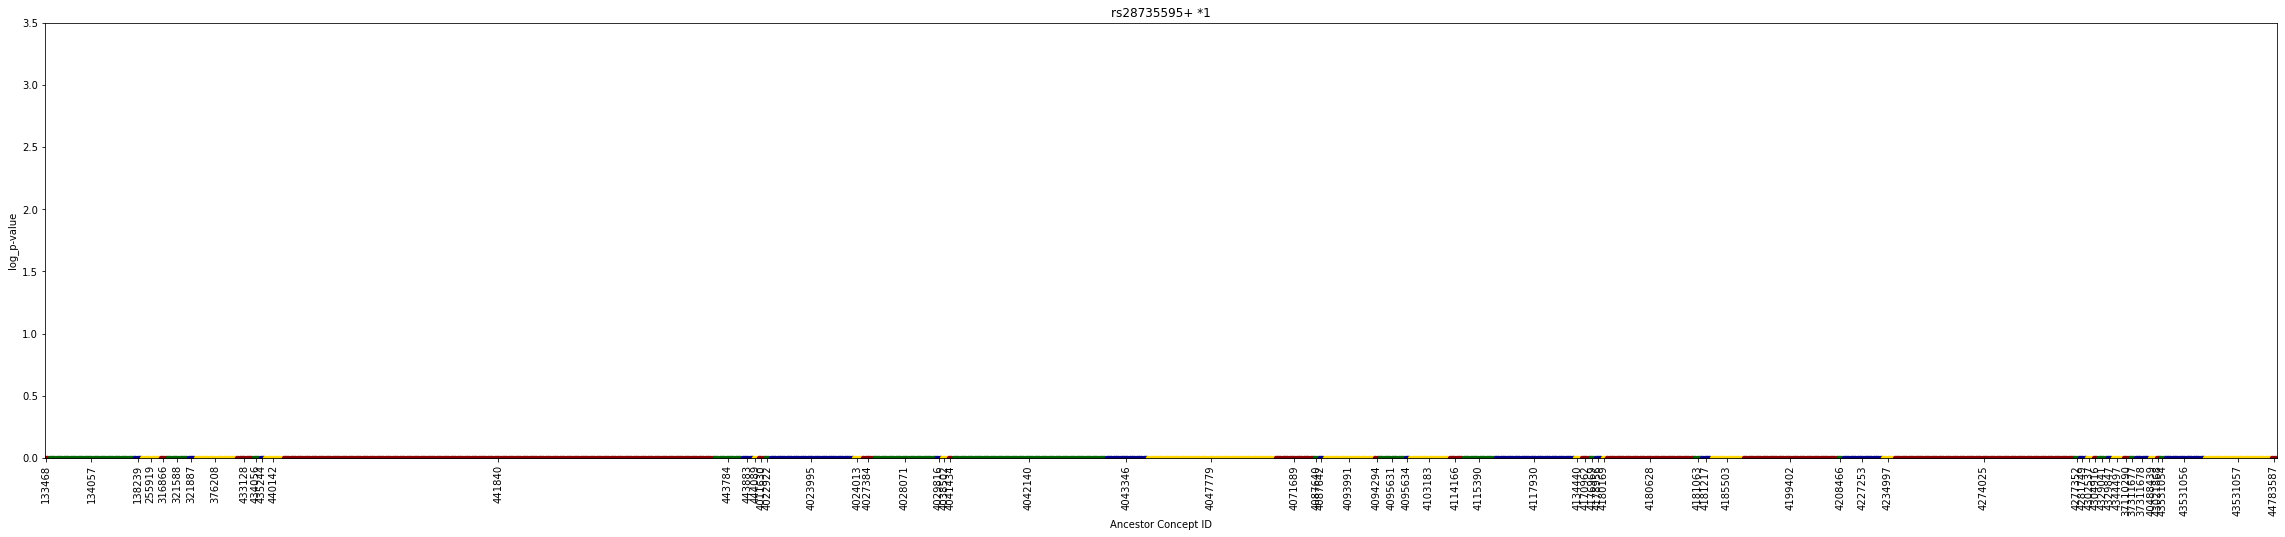

<Figure size 432x288 with 0 Axes>

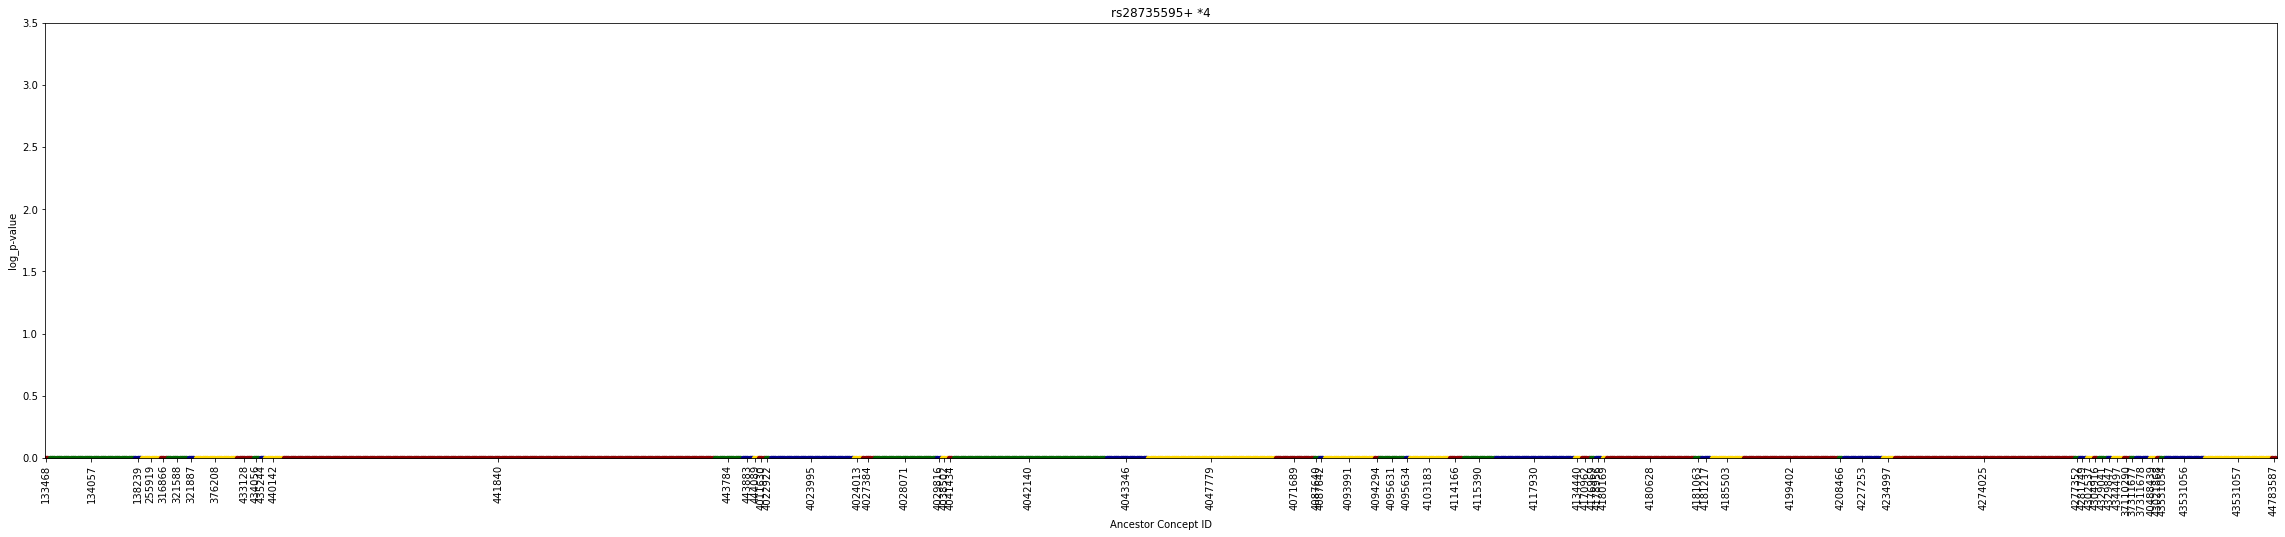

<Figure size 432x288 with 0 Axes>

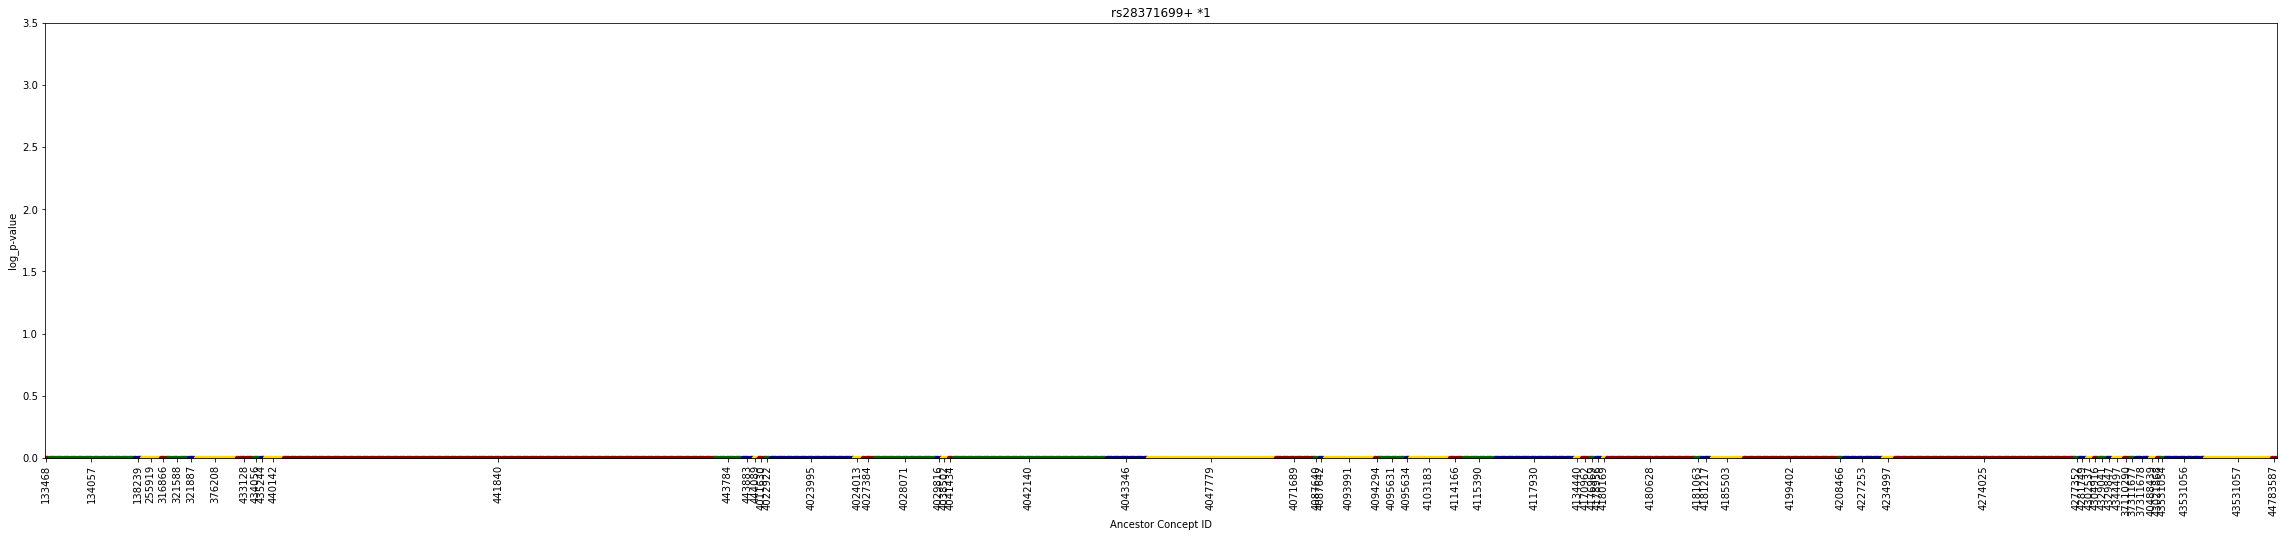

<Figure size 432x288 with 0 Axes>

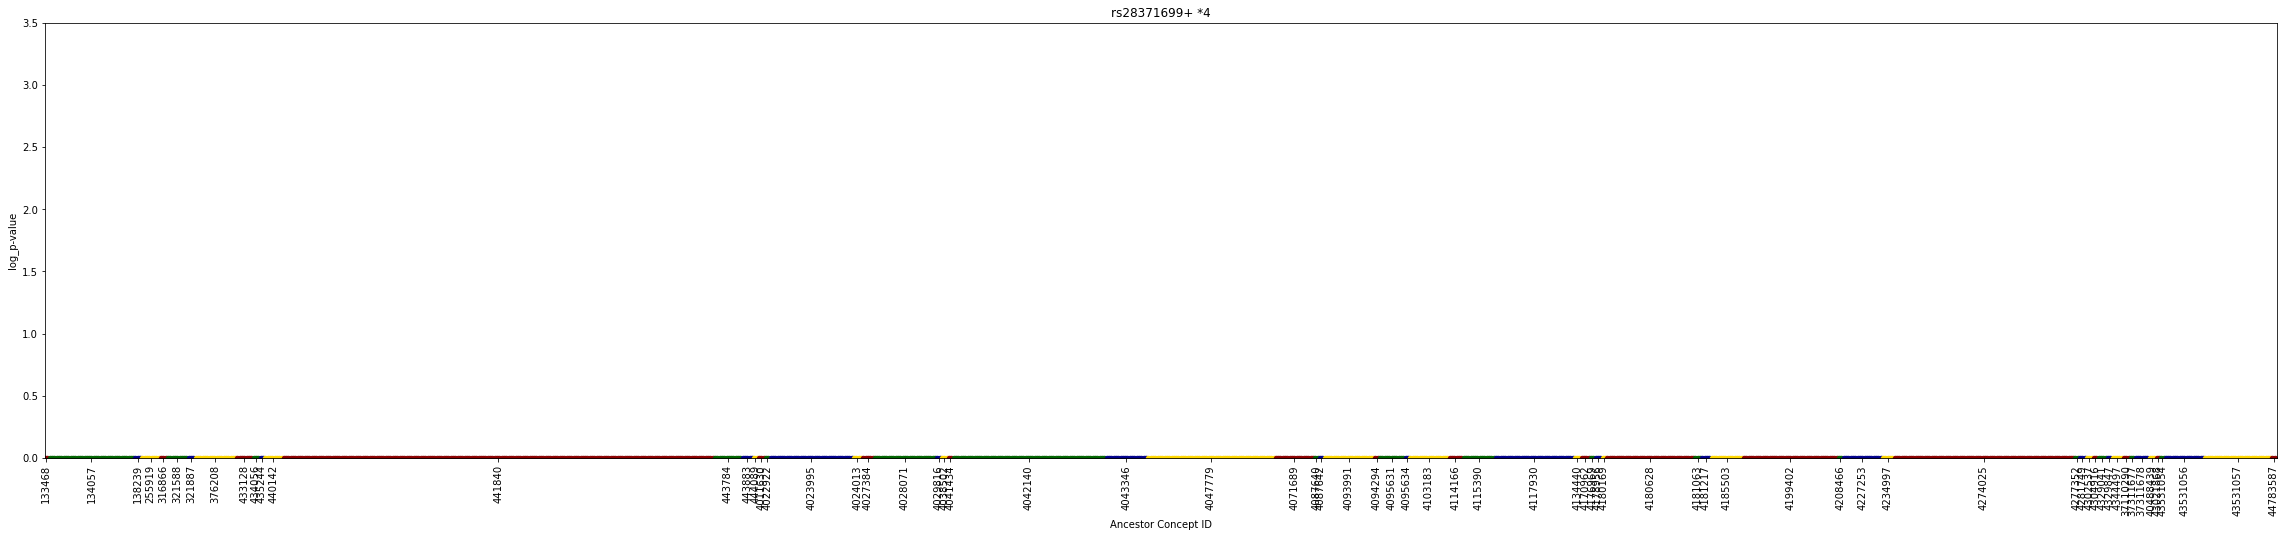

<Figure size 432x288 with 0 Axes>

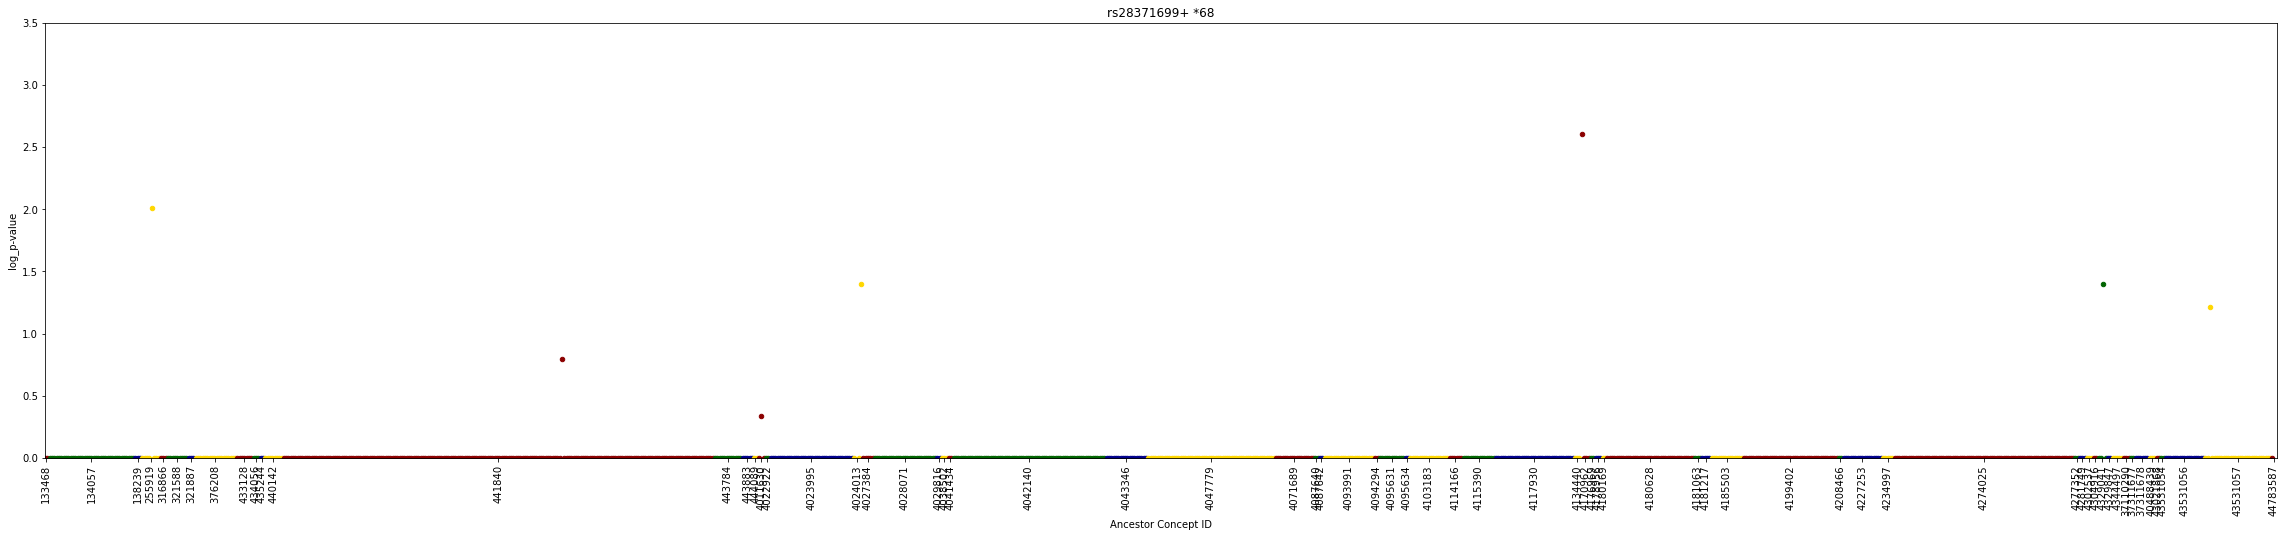

<Figure size 432x288 with 0 Axes>

In [37]:
P = Phenotype_df[Phenotype_df.index.isin(n1["person_id"])]
A = Allele_df[Allele_df.index.isin(n1["person_id"])]

s_output_mapped, s_table = PheWAS(P,A) ## include "rs+1" samples only
manhattan_plot(s_output_mapped,a=1,rs ='rs28735595')
   
#=========================================================

P = Phenotype_df[Phenotype_df.index.isin(n2["person_id"])]
A = Allele_df[Allele_df.index.isin(n2["person_id"])]

s_output_mapped, s_table = PheWAS(P,A) ## include "rs+1" samples only
manhattan_plot(s_output_mapped,a=4,rs ='rs28735595')
   
#=========================================================

P = Phenotype_df[Phenotype_df.index.isin(n3["person_id"])]
A = Allele_df[Allele_df.index.isin(n3["person_id"])]

s_output_mapped, s_table = PheWAS(P,A) ## include "rs+1" samples only
manhattan_plot(s_output_mapped,a=1,rs ='rs28371699')
   
#=========================================================

P = Phenotype_df[Phenotype_df.index.isin(n4["person_id"])]
A = Allele_df[Allele_df.index.isin(n4["person_id"])]

s_output_mapped, s_table = PheWAS(P,A) ## include "rs+1" samples only
manhattan_plot(s_output_mapped,a=4,rs ='rs28371699')
   
#=========================================================

P = Phenotype_df[Phenotype_df.index.isin(n5["person_id"])]
A = Allele_df[Allele_df.index.isin(n5["person_id"])]

s_output_mapped, s_table = PheWAS(P,A) ## include "rs+1" samples only
manhattan_plot(s_output_mapped,a=68,rs ='rs28371699')

In [38]:
s_table

,ancestor_concept_id,standard_concept_name
2533,133468,Disorder of extremity
50362,134057,Disorder of cardiovascular system
15916,135930,Musculoskeletal finding
7950,138239,Finding of limb structure
55436,141084,Pre-eclampsia or eclampsia with pre-existing h...
...,...,...
33200,43531057,NaN
32924,43531058,Finding of abdomen
38266,43531059,Finding of pelvic region of trunk
4197,44783587,NaN


In [17]:
Allele_df[Allele_df.index.isin(n1["person_id"])]

,1,2,3,4,6,7,8,9,10,12,...,122,125,126,127,131,136,139,146,158,160
1695760,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1818645,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3186728,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1597598,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1048766,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916688,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1826605,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1490771,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1900374,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
